In [1]:
using Pkg, Revise
Pkg.activate("..")
using Clapeyron, PyCall
import PyPlot; const plt = PyPlot

  Activating project at `~/Library/CloudStorage/OneDrive-CaliforniaInstituteofTechnology/University/UROP/SAFT_codes/Clapeyron`


PyPlot

In this notebook, we'll be giving examples of how one can predict solid-liquid and solid-liquid-liquid equilibrium in `Clapeyron.jl`. These calculations make extensive use of the `CompositeModel` approach where a model is constructed from multiple other models to fully represent a given system:
```julia
struct CompositeModel{𝕍,𝕃,𝕊,𝕃𝕍,𝕃𝕊} <: EoSModel
    components::Vector{String}
    gas::𝕍
    liquid::𝕃
    solid::𝕊
    saturation::𝕃𝕍
    melting::𝕃𝕊
end
```
In our case, we will use the `SolidHfus` model to represent the solid phase, and change the model used to represent the fluid phases.


## Solid-liquid equilibrium of a Solute
As a first step, let us consider the solubility of ibuprofen in water. We will use PC-SAFT to represent the fluid phase:

In [2]:
model = CompositeModel(["water","paracetamol"];fluid=PCSAFT,solid=SolidHfus)

Composite Model with 2 components:
 Solid Model: SolidHfus("water", "paracetamol")
 Fluid Model: PCSAFT{BasicIdeal, Float64}("water", "paracetamol")

From here, the solubility of paracetamol can be obtained as:

In [4]:
T = 298.15
p = 1e5
z = [1.,0.]
s = sle_solubility(model,p,T,[1.,0.];solute=["paracetamol"])

ErrorException: type PCSAFT has no field liquid

The output here is the composition of each component in the liquid phase in equilibrium with the pure solid phase of paracetamol. Note that the composition in the `z` is treated as solute-free. From here, we can plot the temperature-dependence of the solubility: 

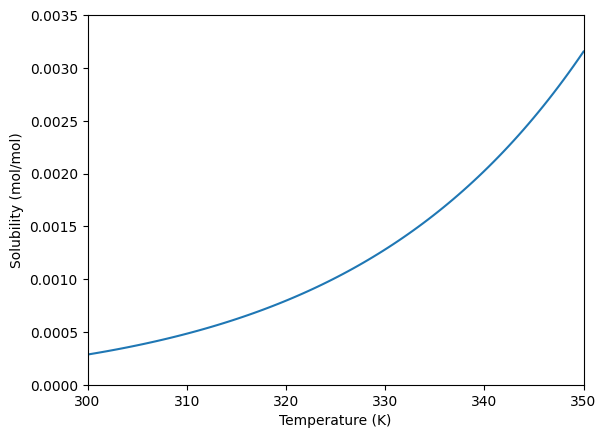

In [15]:
T = LinRange(300.,350.,100)
p = 1e5 

s = zeros(length(T))

for i in 1:length(T)
    s[i] = sle_solubility(model,p,T[i],[1.,0.];solute=["paracetamol"])[2]
end

plt.clf()
plt.plot(T,s)
plt.xlabel("Temperature (K)")
plt.ylabel("Solubility (mol/mol)")
plt.ylim(0,0.0035)
plt.xlim(300,350)
display(plt.gcf())

We can also model the solubility of sollutes in a mixture solvent. For example, consider the solubility of ibuprofen in a mixture of water+ethanol. This time, we will use UNIFAC, we we need to specify the groups of ibuprofen:

In [16]:
model = CompositeModel(["water","ethanol",("ibuprofen",["ACH"=>4,"ACCH2"=>1,"ACCH"=>1,"CH3"=>3,"COOH"=>1,"CH"=>1])];liquid=UNIFAC,solid=SolidHfus,saturation=nothing)

Composite Model:
 Gas Model: BasicIdeal()
 Liquid Model: UNIFAC{BasicIdeal}("water", "ethanol", "ibuprofen")
 Solid Model: SolidHfus("water", "ethanol", "ibuprofen")


With this, we can obtain the solubility:

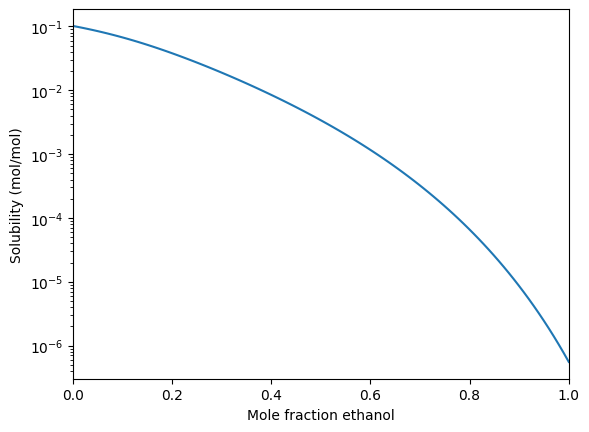

In [22]:
T = 298.15
p = 1e5
x = LinRange(0.,1.,100)

s = zeros(length(x))

for i in 1:length(s)
    s[i] = sle_solubility(model,p,T,[x[i],1-x[i],0.];solute=["ibuprofen"])[3]
end

plt.clf()
plt.semilogy(x,s)
plt.xlabel("Mole fraction ethanol")
plt.ylabel("Solubility (mol/mol)")
plt.xlim(0,1)
display(plt.gcf())

## Solid-liquid equilibrium of a Eutectic Mixture

One type of phase diagram that might be interesting is when considering a eutectic mixture where we are below the melting temperature of both components. For this case, we will consider multiple equations of state for the fluid phase:

In [24]:
model1 = CompositeModel([("1-decanol",["CH3"=>1,"CH2"=>9,"OH (P)"=>1]),("thymol",["ACCH3"=>1,"ACH"=>3,"ACOH"=>1,"ACCH"=>1,"CH3"=>2])];liquid=UNIFAC,solid=SolidHfus,saturation=nothing)
model2 = CompositeModel(["1-decanol","thymol"];fluid=PCSAFT,solid=SolidHfus)
model3 = CompositeModel([("1-decanol",["CH3"=>1,"CH2"=>8,"CH2OH"=>1]),("thymol",["aCCH3"=>1,"aCH"=>3,"aCOH"=>1,"aCCH"=>1,"CH3"=>2])];fluid=SAFTgammaMie,solid=SolidHfus)
models = [model1,model2,model3]

3-element Vector{CompositeModel{𝕍, 𝕃, SolidHfus, 𝕃𝕍, Nothing} where {𝕍, 𝕃, 𝕃𝕍}}:
 CompositeModel{BasicIdeal, UNIFAC{BasicIdeal}, SolidHfus, Nothing, Nothing}("1-decanol", "thymol")
 CompositeModel{PCSAFT{BasicIdeal, Float64}, PCSAFT{BasicIdeal, Float64}, SolidHfus, PCSAFT{BasicIdeal, Float64}, Nothing}("1-decanol", "thymol")
 CompositeModel{SAFTgammaMie{BasicIdeal, SAFTVRMie{BasicIdeal}}, SAFTgammaMie{BasicIdeal, SAFTVRMie{BasicIdeal}}, SolidHfus, SAFTgammaMie{BasicIdeal, SAFTVRMie{BasicIdeal}}, Nothing}("1-decanol", "thymol")

In this case, because both components are in the solid phase, it is best we obtain the solid-liquid phase boundary for each solid phase in equilibrium with the liquid phase. The end point of these lines will be the eutectic temperature, which can be obtained using `eutectic_point`. The full calculation is shown below:

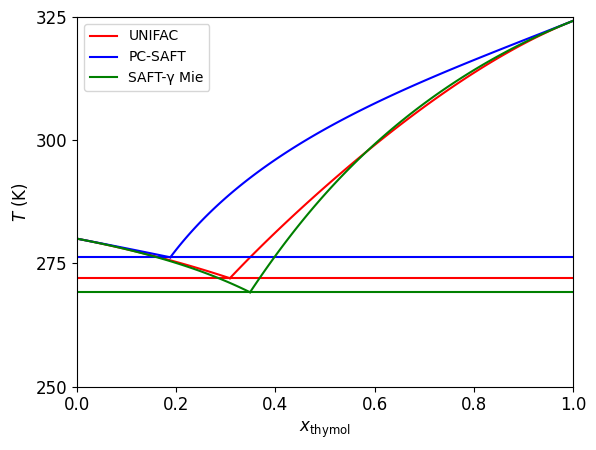

In [26]:
plt.clf()

color = ["red","blue","green"]

names = ["UNIFAC","PC-SAFT","SAFT-γ Mie"]

for k in 1:3
    sol = zeros(100,2)
    T = zeros(100,2)
    model = models[k]

    # Use the melting temperatures as the starting points
    Tm = model.solid.params.Tm.values

    # Obtain the eutetic temperature as the end point
    TE = eutectic_point(model)[1]

    # Consider each side of the SLE curve separately
    for i in 1:length(Tm)
        T[:,i] = LinRange(TE,Tm[i]*0.9999,100)
        for j in 1:length(T[:,i])
            sol[j,i] = sle_solubility(model,1e5,T[j,i],ones(2);solute=[model.components[i]])[1]
        end
        
    end
    plt.plot(1 .-sol,T,color=color[k])
    plt.plot([0.,1.],[TE,TE],color=color[k],linestyle="-",label=names[k])
end
plt.xlabel(raw"$x_\mathrm{thymol}$",fontsize=12)
plt.ylabel(raw"$T$ (K)",fontsize=12)
plt.legend()
plt.ylim(250,325)
plt.xlim(0,1)
plt.yticks(LinRange(250,325,4),fontsize=12)
plt.xticks(fontsize=12)

display(plt.gcf())

## Solid-liquid-liquid equilibrium
It is possible that, at certain conditions, our system will observe liquid-liquid equilibrium. And this liquid-liquid equilibrium may intersect with out solid-liquid equilibrium curve. As such, we need to determine where this solid-liquid-liquid equilibrium (SLLE) region is to trace our full phase diagram. As an example, we consider the water, ethanol and ibuprofen mixture with UNIFAC:

In [6]:
model = CompositeModel(["water","ethanol",("ibuprofen",["aCH"=>4,"aCCH2"=>1,"aCCH"=>1,"CH3"=>3,"COOH"=>1,"CH"=>1])];fluid=SAFTgammaMie,solid=SolidHfus,saturation=nothing)

Composite Model:
 Gas Model: SAFTgammaMie{BasicIdeal, SAFTVRMie{BasicIdeal}}("water", "ethanol", "ibuprofen")
 Liquid Model: SAFTgammaMie{BasicIdeal, SAFTVRMie{BasicIdeal}}("water", "ethanol", "ibuprofen")
 Solid Model: SolidHfus("water", "ethanol", "ibuprofen")

 Saturation Model: SAFTgammaMie{BasicIdeal, SAFTVRMie{BasicIdeal}}("water", "ethanol", "ibuprofen")

For this mixture, SLLE can be observed at 313.15 K. The first step is to trace the full SLE curve:

In [16]:
T = 313.15
p = 1e5

x = LinRange(0.,1.,100)
wsolu = zeros(100)
wsolv = zeros(100)
names = ["water","ethanol","ibuprofen"]
Mw = [18.01528,46.06844,206.282]

for i in 1:100
    s = sle_solubility(model,p,T,[x[i],1-x[i],0.0];solute=["ibuprofen"])
    wsolu[i] = s[3]*Mw[3]/(s[3]*Mw[3]+s[2]*Mw[2]+s[1]*Mw[1])
    wsolv[i] = s[1]*Mw[1]/(s[3]*Mw[3]+s[2]*Mw[2]+s[1]*Mw[1])
end

Subsequently, we can obtain the SLLE point using `slle_solubility` which will give the composition of the two liquid phases in equilibrium with each other and solid ibuprofen:

In [20]:
(s1,s2) = Clapeyron.slle_solubility(model,p,T)
wsolu1 = s1[3]*Mw[3]/(s1[3]*Mw[3]+s1[2]*Mw[2]+s1[1]*Mw[1])
wsolv1 = s1[1]*Mw[1]/(s1[3]*Mw[3]+s1[2]*Mw[2]+s1[1]*Mw[1])

wsolu2 = s2[3]*Mw[3]/(s2[3]*Mw[3]+s2[2]*Mw[2]+s2[1]*Mw[1])
wsolv2 = s2[1]*Mw[1]/(s2[3]*Mw[3]+s2[2]*Mw[2]+s2[1]*Mw[1]);

Finally, to complete the phase diagram, we trace the liquid-liquid equilibrium (LLE) region using our flash algorithms:

In [21]:
x = zeros(100,3)
x[1,:] = s2
xx = zeros(100,3)
xx[1,:] = s1

z = (s1+s2)/2+[0,1,0]*1e-2
z ./= sum(z)
K0 = s2./s1
idx_end = 100

for i in 2:100
        (X,n,G) = tp_flash(model.fluid,p,T,z,RRTPFlash(K0=K0,equilibrium=:lle))
        if X[2,2]-X[1,2] < 1e-3
            idx_end=i-1
            break
        end
        xx[i,:] = X[1,:]
        x[i,:] = X[2,:]
        K0 = X[2,:]./X[1,:]
        dx = x[i,:]-x[i-1,:]
        dxx = xx[i,:]-xx[i-1,:]
        dz = (dx+dxx)/2
        z += dz
end

wsolv_lle1 = @. x[:,1]*Mw[1]/(x[:,3]*Mw[3]+x[:,2]*Mw[2]+x[:,1]*Mw[1])
wsolu_lle1 = @. x[:,3]*Mw[3]/(x[:,3]*Mw[3]+x[:,2]*Mw[2]+x[:,1]*Mw[1])

wsolv_lle2 = @. xx[:,1]*Mw[1]/(xx[:,3]*Mw[3]+xx[:,2]*Mw[2]+xx[:,1]*Mw[1])
wsolu_lle2 = @. xx[:,3]*Mw[3]/(xx[:,3]*Mw[3]+xx[:,2]*Mw[2]+xx[:,1]*Mw[1])

wsolv_lle = vcat(wsolv_lle1[1:idx_end],reverse(wsolv_lle2[1:idx_end]))
wsolu_lle = vcat(wsolu_lle1[1:idx_end],reverse(wsolu_lle2[1:idx_end]));

Finally, we can compile everything within a single diagram:

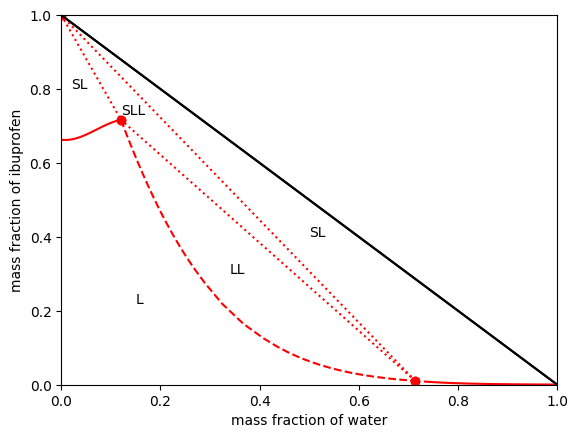

In [34]:
plt.clf()
plt.plot([0,1],[1,0],"k-")

plt.plot(wsolv[wsolv.<=wsolv2],wsolu[wsolv.<=wsolv2],color="red")
plt.plot(wsolv[wsolv.>=wsolv1],wsolu[wsolv.>=wsolv1],color="red")
plt.plot(wsolv_lle,wsolu_lle,color="red",linestyle="--")

plt.plot([wsolv1,wsolv2],[wsolu1,wsolu2],"ro:",markerfacecolor="r")
plt.plot([wsolv1,0],[wsolu1,1],"ro:",markerfacecolor="r")
plt.plot([0,wsolv2],[1,wsolu2],"ro:",markerfacecolor="r")
plt.plot([0,1],[1,0],"k-")
plt.text(0.02,0.8,"SL")
plt.text(0.5,0.4,"SL")
plt.text(0.34,0.3,"LL")
plt.text(0.12,0.73,"SLL")
plt.text(0.15,0.22,"L")

plt.xlabel(raw"mass fraction of water")
plt.ylabel(raw"mass fraction of ibuprofen")
plt.xlim(0,1)
plt.ylim(0,1)
display(plt.gcf())

This gives us a very good image of the phase space one has to work with when dealing with a mixture of ibuprofen, ethanol and water.